In [4]:
import pennylane as qml
import numpy as np
import jax

In [5]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

dev = qml.device("default.qubit", wires=1)
H = 0.6 * qml.PauliZ(0) - 0.8 * qml.PauliY(0)


def qfunc(theta):
    qml.SpecialUnitary(theta, wires=0)
    return qml.expval(H)


circuit = qml.QNode(qfunc, dev, interface="jax", diff_method="parameter-shift")

theta = jnp.array([0.4, 0.2, -0.5])

In [6]:
unit_vector = np.array([0.0, 1.0, 0.0])


def central_diff_grad(theta, delta):
    plus_eval = circuit(theta + delta / 2 * unit_vector)
    minus_eval = circuit(theta - delta / 2 * unit_vector)
    return (plus_eval - minus_eval) / delta


delta = 0.75
print(f"Central difference: {central_diff_grad(theta, delta):.5f}")

Central difference: 0.42398


In [7]:
@jax.jit
@qml.qnode(dev, interface="jax")
def aux_circuit(theta, tau, sign):
    qml.SpecialUnitary(tau * theta, wires=0)
    # This corresponds to the parameter-shift evaluations of RY at 0
    qml.RY(-sign * np.pi / 2, wires=0)
    qml.SpecialUnitary((1 - tau) * theta, wires=0)
    return qml.expval(H)


def stochastic_parshift_grad(theta, num_samples):
    grad = 0
    splitting_times = np.random.random(size=num_samples)
    for tau in splitting_times:
        # Evaluate the two-term parameter-shift rule of the auxiliar circuit
        grad += aux_circuit(theta, tau, 1.0) - aux_circuit(theta, tau, -1.0)
    return grad / num_samples


num_samples = 10
print(f"Stochastic parameter-shift: {stochastic_parshift_grad(theta, num_samples):.5f}")

Stochastic parameter-shift: 0.63324


In [8]:
sun_grad = jax.grad(circuit)
print(f"Custom SU(N) gradient: {sun_grad(theta)[1]:.5f}")

Custom SU(N) gradient: 0.42609


In [9]:
autodiff_circuit = qml.QNode(qfunc, dev, interface="jax", diff_method="parameter-shift")
exact_grad = jax.grad(autodiff_circuit)(theta)[1]
print(f"Exact gradient: {exact_grad:.5f}")

Exact gradient: 0.42609


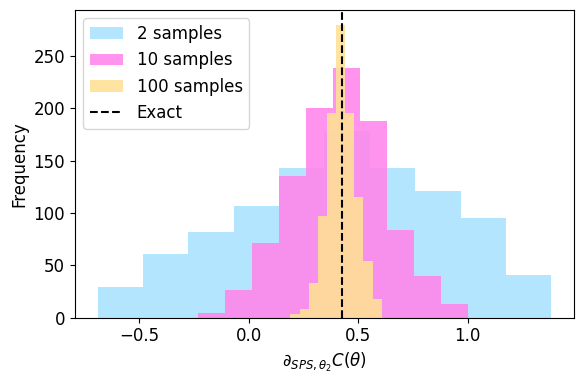

In [10]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 12})

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
colors = ["#ACE3FF", "#FF87EB", "#FFE096"]
for num_samples, color in zip([2, 10, 100], colors):
    grads = [stochastic_parshift_grad(theta, num_samples) for _ in range(1000)]
    ax.hist(grads, label=f"{num_samples} samples", alpha=0.9, color=color)
ylim = ax.get_ylim()
ax.plot([exact_grad] * 2, ylim, ls="--", c="k", label="Exact")
ax.set(xlabel=r"$\partial_{SPS,\theta_2}C(\theta)$", ylabel="Frequency", ylim=ylim)
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [11]:
def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)


# The three building blocks on two qubits we will compare are:
operations = {
    ("Decomposition", "decomposition"): two_qubit_decomp,
    ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
    ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
}

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_35853/391022573.py:24: SyntaxWarning: invalid escape sequence '\m'
  ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,


In [12]:
num_wires = 6
wires = list(range(num_wires))
np.random.seed(62213)

coefficients = np.random.randn(4**num_wires - 1)
# Create the matrices for the entire Pauli basis
basis = qml.ops.qubit.special_unitary.pauli_basis_matrices(num_wires)
# Construct the Hamiltonian from the normal random coefficients and the basis
H_matrix = qml.math.tensordot(coefficients, basis, axes=[[0], [0]])
H = qml.Hermitian(H_matrix, wires=wires)
# Compute the ground state energy
E_min = min(qml.eigvals(H))
print(f"Ground state energy: {E_min:.5f}")

Ground state energy: -119.70320


In [13]:
loc = 2
d = loc**4 - 1  # d = 15 for two-qubit operations
dev = qml.device("default.qubit", wires=num_wires)
# two blocks with two layers. Each layer contains three operations with d parameters
param_shape = (2, 2, 3, d)
init_params = np.zeros(param_shape)


def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                print("performing",  operation, "operations", " on ", wires_op, "params", params_op)
                operation(params_op, wires_op)
    return qml.expval(H)


qnode = qml.QNode(circuit, dev, interface="jax")
print(qml.draw(qnode)(init_params, qml.SpecialUnitary))

performing <class 'pennylane.ops.qubit.special_unitary.SpecialUnitary'> operations  on  [0, 1] params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
performing <class 'pennylane.ops.qubit.special_unitary.SpecialUnitary'> operations  on  [2, 3] params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
performing <class 'pennylane.ops.qubit.special_unitary.SpecialUnitary'> operations  on  [4, 5] params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
performing <class 'pennylane.ops.qubit.special_unitary.SpecialUnitary'> operations  on  [1, 2] params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
performing <class 'pennylane.ops.qubit.special_unitary.SpecialUnitary'> operations  on  [3, 4] params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
performing <class 'pennylane.ops.qubit.special_unitary.SpecialUnitary'> operations  on  [5, 0] params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
performing <class 'pennylane.ops.qubit.special_unitary.SpecialUnitary'> operations  on  [0, 1] params [0. 

In [14]:
# for auto-differentiation.

learning_rate = 5e-4
num_steps = 500
init_params = jax.numpy.array(init_params)
grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)
qnode = jax.jit(qnode, static_argnums=1)

In [15]:
energies = {}

# # The three building blocks on two qubits we will compare are:
# operations = {
#     ("Decomposition", "decomposition"): two_qubit_decomp,
#     ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
#     ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
# }
for (name, print_name), operation in operations.items(): 
    print(f"Running the optimization for the {print_name}")
    params = init_params.copy()
    energy = []
    for step in range(num_steps):
        cost = qnode(params, operation)
        params = params - learning_rate * grad_fn(params, operation)
        energy.append(cost)  # Store energy value
        if step % 50 == 0:  # Report current energy
            print(f"{step:3d} Steps: {cost:.6f}")

    energy.append(qnode(params, operation))  # Final energy value
    energies[name] = energy

Running the optimization for the decomposition
performing <function two_qubit_decomp at 0x32e877f60> operations  on  [0, 1] params Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace(level=1/0)>
performing <function two_qubit_decomp at 0x32e877f60> operations  on  [2, 3] params Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace(level=1/0)>
performing <function two_qubit_decomp at 0x32e877f60> operations  on  [4, 5] params Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace(level=1/0)>
performing <function two_qubit_decomp at 0x32e877f60> operations  on  [1, 2] params Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace(level=1/0)>
performing <function two_qubit_decomp at 0x32e877f60> operations  on  [3, 4] params Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace(level=1/0)>
performing <function two_qubit_decomp at 0x32e877f60> operations  on  [5, 0] params Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace(level=1/0)>
performing <function two_qubit_decomp at 0x32e8

/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


  0 Steps: 0.108347
 50 Steps: -63.548081
100 Steps: -84.956818
150 Steps: -94.176547
200 Steps: -100.707290
250 Steps: -104.434910
300 Steps: -106.567958
350 Steps: -108.110054
400 Steps: -109.453172
450 Steps: -110.748710


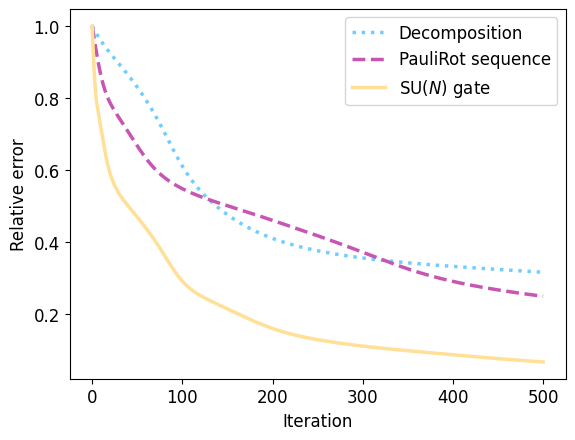

In [16]:
fig, ax = plt.subplots(1, 1)
styles = [":", "--", "-"]
colors = ["#70CEFF", "#C756B2", "#FFE096"]
for (name, energy), c, ls in zip(energies.items(), colors, styles):
    error = (energy - E_min) / abs(E_min)
    ax.plot(list(range(len(error))), error, label=name, c=c, ls=ls, lw=2.5)

ax.set(xlabel="Iteration", ylabel="Relative error")
ax.legend()
plt.show()